# 数据介绍

使用 Max Planck Institute for Biogeochemistry 的天气时间序列数据集。

该数据集包含14个不同的特征，例如气温，大气压力和湿度。从2003年开始，每10分钟收集一次。为了提高效率，本文仅使用2009年至2016年之间收集的数据。

In [1]:
#导入需要的库
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (3, 2)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


如上所示，每10分钟记录一次观测值，一个小时内有6个观测值，一天有144（6x24）个观测值。

给定一个特定的时间，假设要预测未来6小时的温度。为了做出此预测，选择使用5天的观察时间。因此，创建一个包含最后720（5x144）个观测值的窗口以训练模型。

下面的函数返回上述时间窗以供模型训练。参数 history_size 是过去信息的滑动窗口大小。target_size 是模型需要学习预测的未来时间步，也作为需要被预测的标签。

下面使用数据的前300,000行当做训练数据集，其余的作为验证数据集。总计约2100天的训练数据。

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history`1_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [4]:
for i in range(0,10):
    indices = range(i-20, i)
    print(indices)

range(-20, 0)
range(-19, 1)
range(-18, 2)
range(-17, 3)
range(-16, 4)
range(-15, 5)
range(-14, 6)
range(-13, 7)
range(-12, 8)
range(-11, 9)


In [5]:
TRAIN_SPLIT = 300000

In [6]:
# 设置种子以确保可重复性。
tf.random.set_seed(13)

# 单变量单步
首先，使用一个特征（温度）训练模型，并在使用该模型做预测。

## 从数据集中提取温度

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

## 观察数据随时间变化的情况

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

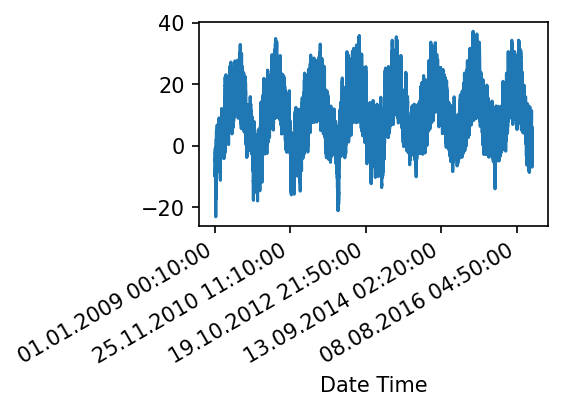

In [8]:
uni_data.plot(subplots=True)

In [9]:
#将数据集转换为数组类型
uni_data = uni_data.values

In [10]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

## 标准化

In [11]:
#标准化
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

用前history_size个时间点的温度预测第history_size+target_size+1个时间点的温度。start_index和end_index表示数据集datasets起始的时间点，我们将要从这些时间点中取出特征和标签。

每个样本有20个特征（即20个时间点的温度信息），其标签为第21个时间点的温度值，如：



In [12]:
#写函数来划分特征和标签
univariate_past_history = 20
univariate_future_target = 0
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, # 起止区间
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

可见第一个样本的特征为前20个时间点的温度，其标签为第21个时间点的温度。根据同样的规律，第二个样本的特征为第2个时间点的温度值到第21个时间点的温度值，其标签为第22个时间点的温度……

In [13]:
x_train_uni.shape

(299980, 20, 1)

In [14]:
y_train_uni.shape

(299980,)

In [15]:
x_val_uni.shape

(120531, 20, 1)

In [16]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


## 设置绘图函数

In [17]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0]) # 横轴刻度
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [18]:
create_time_steps(x_train_uni[0].shape[0])

[-20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1]

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

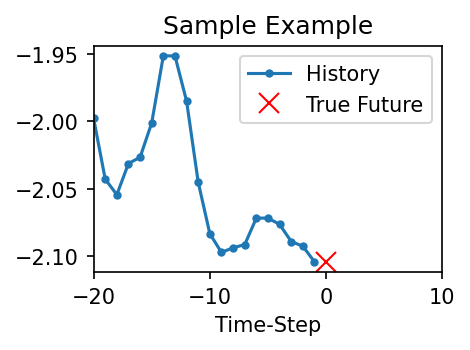

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

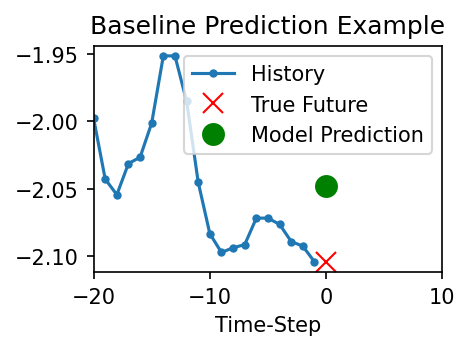

In [20]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## 将特征和标签切片

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

## 建模

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]), # input_shape=(20,1) 不包含批处理维度
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

## 训练模型

In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 7ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0317 - val_loss: 0.0223
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0287 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0263 - val_loss: 0.0198
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0173

In [24]:
print(val_univariate)

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


In [25]:
print(val_univariate.take(3))

<TakeDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


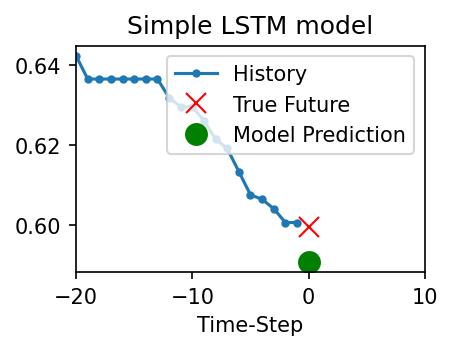

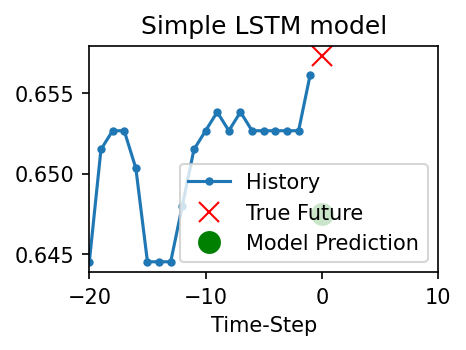

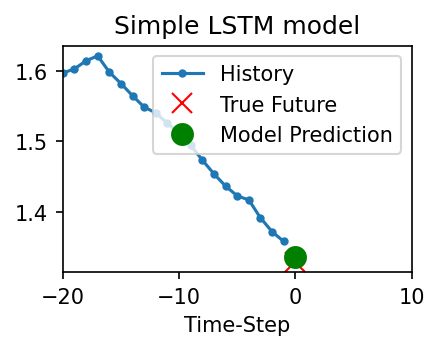

In [26]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

#多变量单步
在这里，我们用过去的一些压强信息、温度信息以及密度信息来预测未来的一个时间点的温度。也就是说，数据集中应该包括压强信息、温度信息以及密度信息。

##从数据集中划分特征和标签

In [27]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [28]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


## 压强、温度、密度随时间变化绘图

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

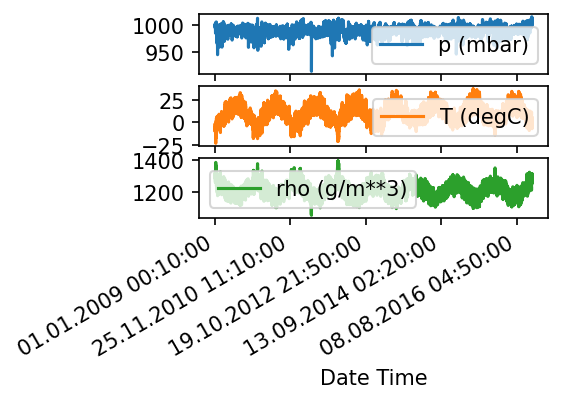

In [29]:
features.plot(subplots=True)

## 将数据集转换为数组类型并标准化

In [30]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

##  写函数来划分特征和标签

在这里，我们不再像单变量单步中一样用到每个数据，而是在函数中加入step参数，这表明所使用的样本每step个时间点取一次特征和标签。

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) # step表示滑动步长
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## 将特征和标签切片

In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

## 建模

In [34]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 14ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2624 - val_loss: 0.2434
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2613 - val_loss: 0.2465
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2568 - val_loss: 0.2449
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2263 - val_loss: 0.2352
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2414 - val_loss: 0.2682
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2406 - val_loss: 0.2554
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2405 - val_loss: 0.2368
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2450 - val_loss: 0.2454
Epoch 10/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2385 - val_lo

In [35]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

## 训练模型

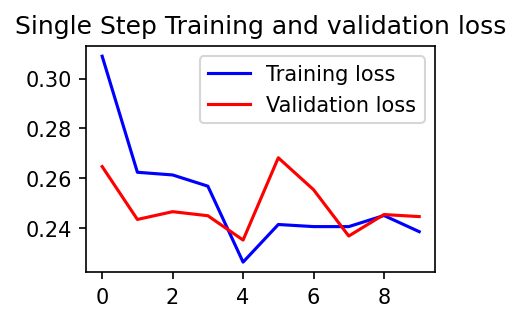

In [36]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## 绘制预测图

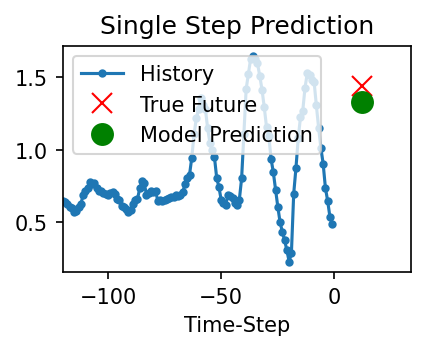

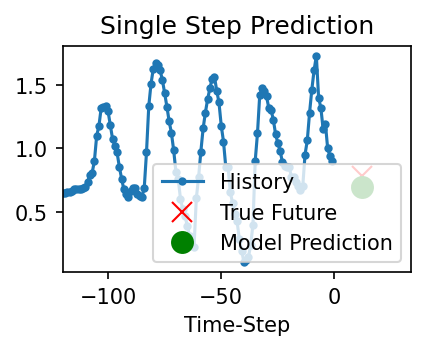

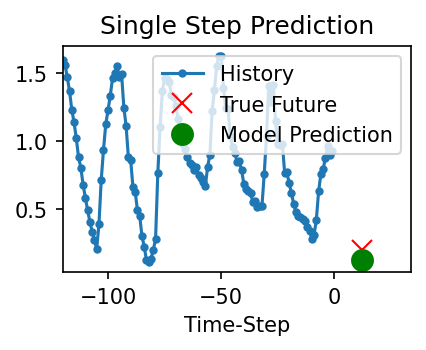

In [37]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

# 多变量多步

##从数据集中划分特征和标签

In [38]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

## 将特征和标签切片

In [39]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 编写绘图函数

In [40]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(3, 2))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

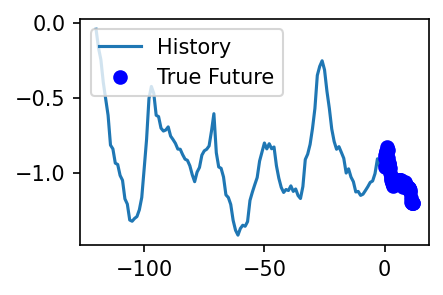

In [41]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

## 建模

In [42]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

## 训练模型

In [43]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 31s 147ms/step - loss: 0.4956 - val_loss: 0.2995
Epoch 2/10
200/200 [==============================] - 29s 144ms/step - loss: 0.3467 - val_loss: 0.2831
Epoch 3/10
200/200 [==============================] - 29s 143ms/step - loss: 0.3313 - val_loss: 0.2452
Epoch 4/10
200/200 [==============================] - 29s 143ms/step - loss: 0.2451 - val_loss: 0.2134
Epoch 5/10
200/200 [==============================] - 29s 143ms/step - loss: 0.1979 - val_loss: 0.2027
Epoch 6/10
200/200 [==============================] - 29s 146ms/step - loss: 0.2063 - val_loss: 0.2097
Epoch 7/10
200/200 [==============================] - 29s 145ms/step - loss: 0.1984 - val_loss: 0.2080
Epoch 8/10
200/200 [==============================] - 28s 141ms/step - loss: 0.1955 - val_loss: 0.1929
Epoch 9/10
200/200 [==============================] - 29s 143ms/step - loss: 0.1968 - val_loss: 0.1889
Epoch 10/10
200/200 [==============================] - 28s 142ms/step - l

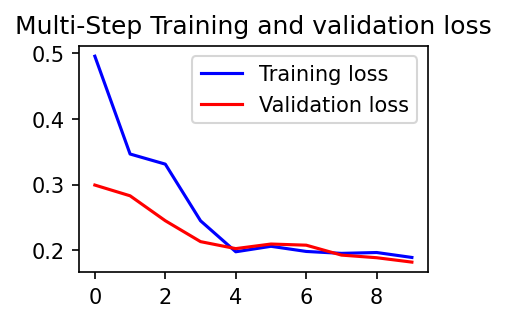

In [44]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## 绘制温度信息

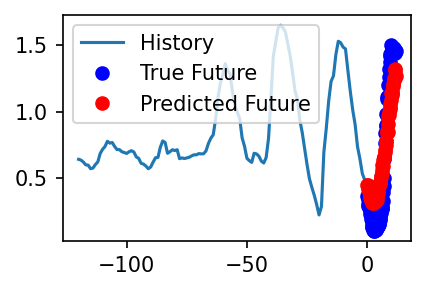

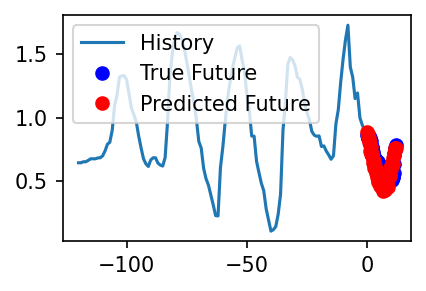

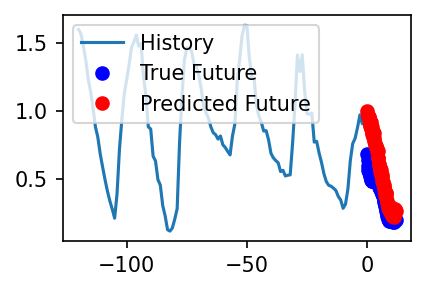

In [45]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])